# Inference on Simulated Data from Generative Model

In [22]:
from sklearn import datasets, neighbors, preprocessing
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from scipy.sparse.csgraph import breadth_first_order
from scipy.sparse.csgraph import laplacian
from scipy.sparse import kron

# local imports
from os import chdir
import os
chdir("../")

#from lllvm import LL_LVM
from lllvm.utils import chol_inv, matrix_normal_log_star, matrix_normal_log_star2
from lllvm2 import LL_LVM2

# Plotting configuration
%matplotlib inline
rcParams['figure.figsize'] = (10,8)
#sns.set()

## Simulate Data From Model

In [23]:
#generate fake data to get a graph that represents data lying on a manifold
x, t_true = datasets.make_swiss_roll(100, 0.01)
x = (x - np.mean(x,0)) / np.array([1, 1, 1])
x = x.T
Dy,N = x.shape
Dt = 1

G = neighbors.kneighbors_graph(x.T, 5, mode='connectivity')
G = G + G.T
G.data = np.ones_like(G.data)
neighbors = G.tolil().rows

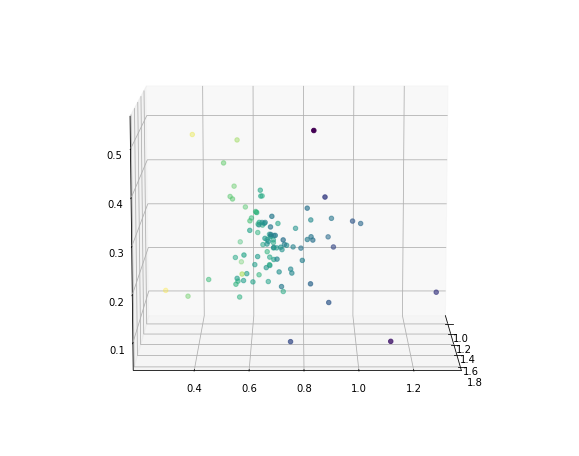

Likelihood under true latent variables:  -348.112321105


In [24]:
#simulate data from the model
alpha = 1.0; gamma =0.000001; epsilon = .0001; V = np.identity(Dy) * gamma

#this isn't actually used; just to get the shapes right
t_init = np.random.multivariate_normal([0] * Dt * N, np.identity(Dt * N)*.5).reshape((1,N))
C_init = np.random.multivariate_normal([0] * Dt * N * Dy, np.identity(Dt * N * Dy)*0.5).reshape(Dy,Dt*N)

model = LL_LVM2(G,epsilon,alpha,V,C_init,t_init,x,.002)
x,t,C = model.simulate()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, -0)
ax.scatter(x[0,:], x[1,:], x[2,:], c=t, marker='o')
plt.show()


model = LL_LVM2(G,epsilon,alpha,V,C,t,x,.002)
print("Likelihood under true latent variables: ", model.likelihood())

## Inference on Simulated Data

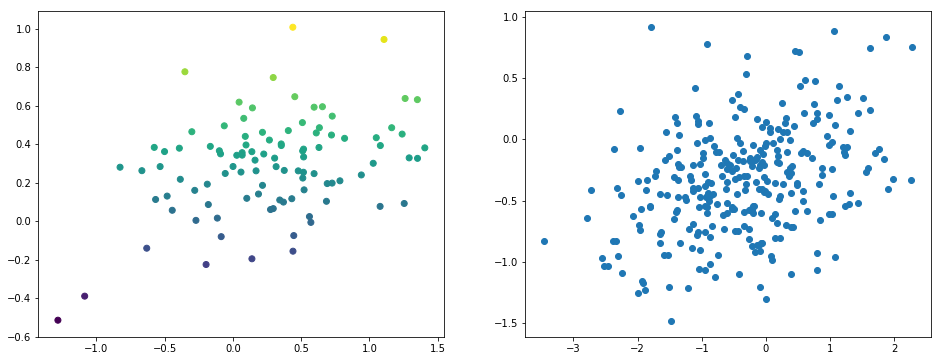

Likelihood under initialization:  -277677613.72


In [42]:
start_node = np.where(breadth_first_order(G,0)[0] == N - 1)[0][0]
# Second, get relative distances from furthest node
order_init, _ = breadth_first_order(G, start_node)
# Finally, assign t_init based on those distances
#t_init = order_init.argsort().reshape(Dt, N).astype(np.float64)
#t_init = (t_init - np.mean(t_init)) / np.std(t_init)
#t_init = np.random.multivariate_normal([0] * Dt * N, np.identity(Dt * N)*.25).reshape((1,N))

t_init = t + np.random.multivariate_normal([0] * Dt * N, np.identity(Dt * N )*0.3).reshape(t.shape)
C_init = C + np.random.multivariate_normal([0] * Dt * N * Dy, np.identity(Dt * N * Dy)*1.0).reshape(Dy,Dt*N)
plt.subplot(1, 2, 1)
plt.scatter(list(t_init),t,c=t)
plt.subplot(1, 2, 2)
plt.scatter(list(C_init),list(C))
plt.show()
model = LL_LVM2(G,epsilon,alpha,V,C_init,t_init,x,.01)
print("Likelihood under initialization: ", model.likelihood())

In [43]:
n_burn = 500

for i in range(n_burn):
    print("\rStep %d of %d, Current Likelihood: %d" % (i+1,n_burn, model.likelihoods[-1]), end="")
    model.MH_step(burn_in=True)

Step 500 of 500, Current Likelihood: -29962875

In [44]:
n_samp = 100                                                                                           

for i in range(n_samp):
    print("\rStep %d of %d, Current Likelihood: %d" % (i+1,n_samp, model.likelihoods[-1]), end="")
    model.MH_step(burn_in=False)

Step 100 of 100, Current Likelihood: -138688

In [45]:
#finish up
t_inferred = model.t_mean

In [46]:
print("Acceptance rate: %.8f" % model.accept_rate)

Acceptance rate: 0.27000000


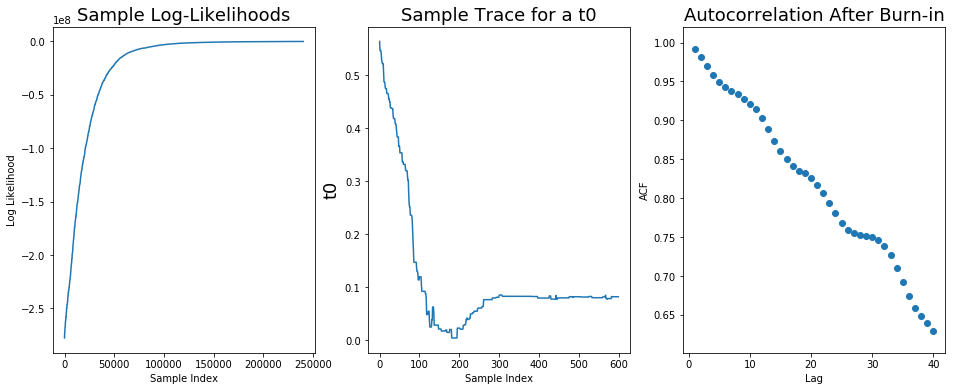

In [47]:
rcParams['figure.figsize'] = (16,6)
plt.subplot(1, 3, 1)
plt.plot(model.likelihoods)
plt.title("Sample Log-Likelihoods", fontsize=18)
plt.ylabel("Log Likelihood", fontsize=10)
plt.xlabel("Sample Index", fontsize=10);
plt.subplot(1, 3, 2)
plt.title("Sample Trace for a t0", fontsize=18)
plt.ylabel("t0", fontsize=18)
plt.xlabel("Sample Index", fontsize=10);
plt.plot(model.trace)
plt.subplot(1, 3, 3)
plt.title("Autocorrelation After Burn-in", fontsize=18)
plt.ylabel("ACF", fontsize=10)
plt.xlabel("Lag", fontsize=10);
plt.scatter(np.arange(1,41),model.autocorrelation(41))
plt.show()

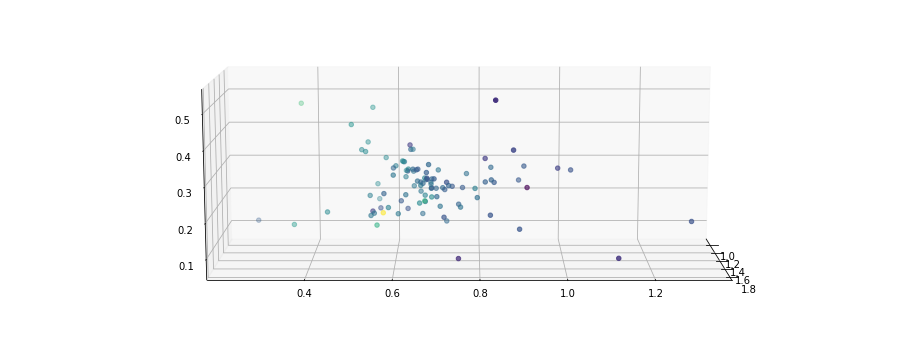

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, -0)
ax.scatter(x[0,:], x[1,:], x[2,:], c=t_inferred[0], marker='o')
plt.show()


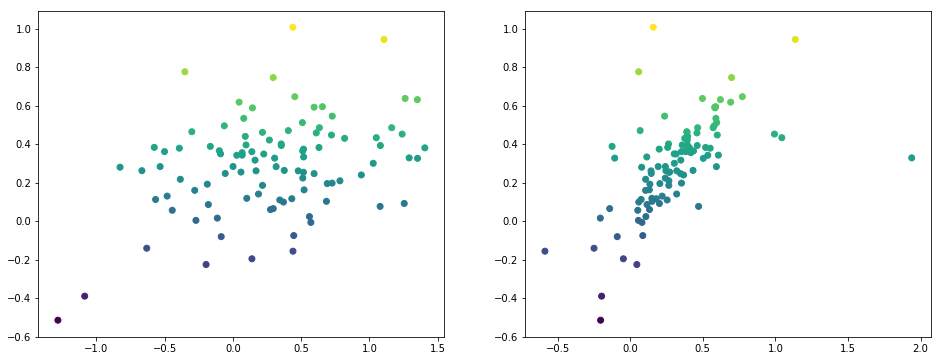

Initial Correlation: r= 0.366406695568
Correlation after Inference: r= 0.601283887076


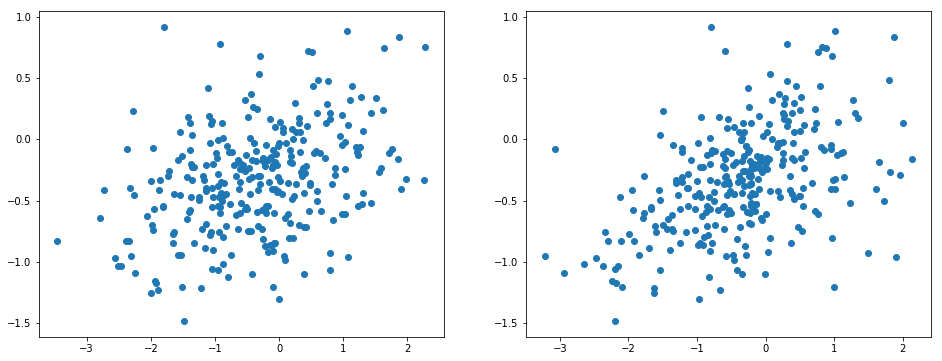

Initial Correlation: r= 0.0528148699058
Correlation after Inference: r= 0.343185544757


In [53]:
plt.subplot(1, 2, 1)
plt.scatter(list(t_init),t,c=t)
plt.subplot(1, 2, 2)
plt.scatter(list(t_inferred),t,c=t)
plt.show()
print("Initial Correlation: r=" ,np.corrcoef(list(t_init),t)[0,1])
print("Correlation after Inference: r=" ,np.corrcoef(list(t_inferred),t)[0,1])

plt.subplot(1, 2, 1)
plt.scatter(list(C_init),list(C))
plt.subplot(1, 2, 2)
len(list(C))
plt.scatter(list(model.C_mean),list(C))
plt.show()
print("Initial Correlation: r=" ,np.corrcoef(list(C_init),list(C))[0,1])
print("Correlation after Inference: r=" ,np.corrcoef(list(model.C_mean),list(C))[0,1])

## Optimizing Step Size

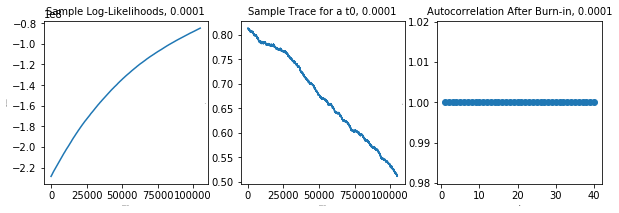

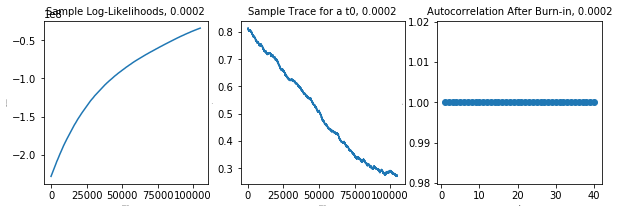

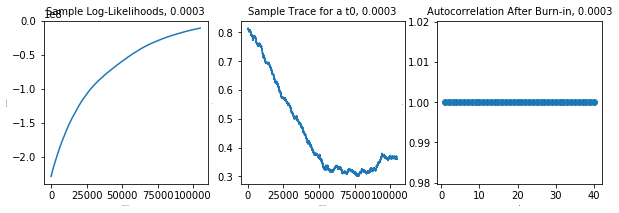

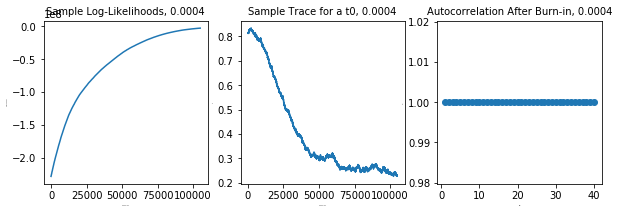

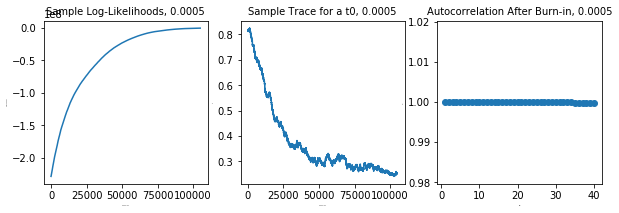

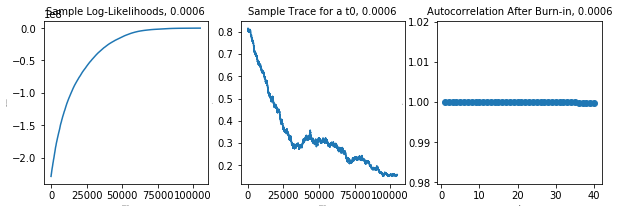

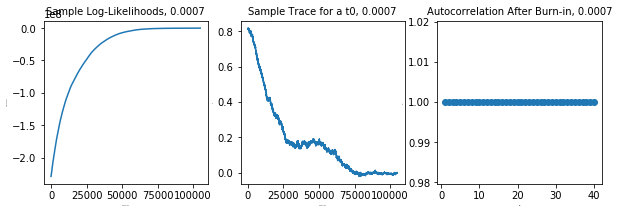

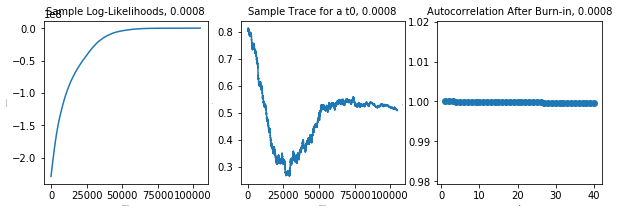

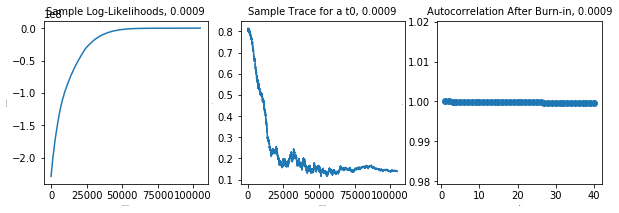

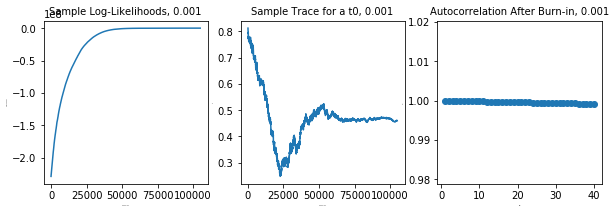

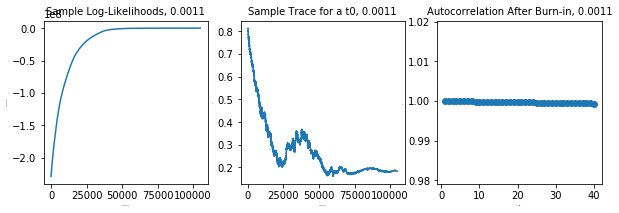

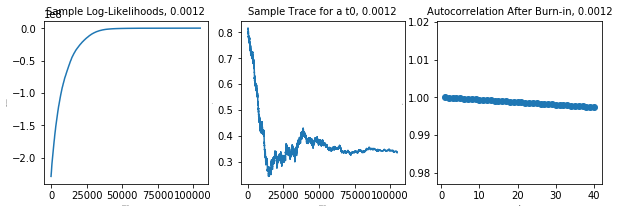

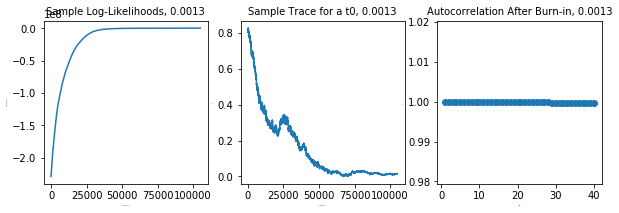

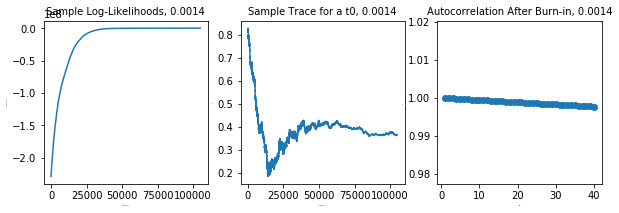

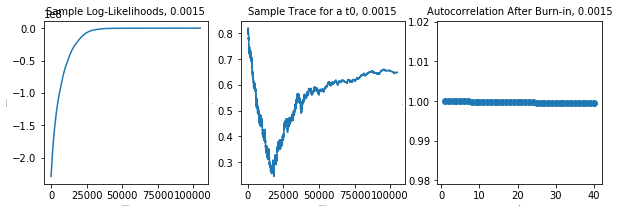

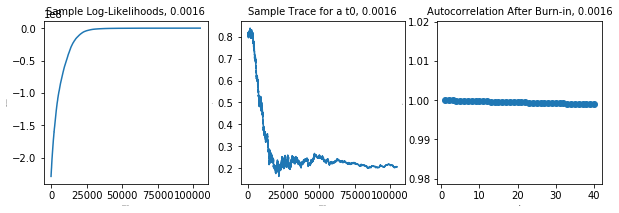

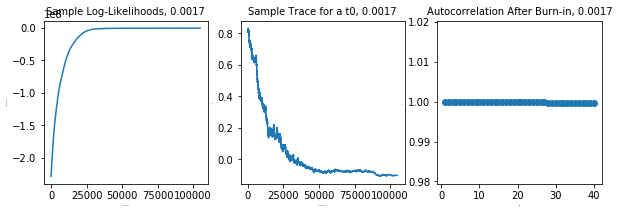

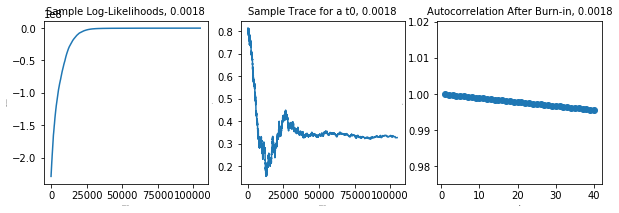

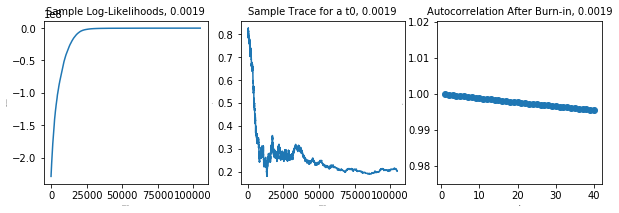

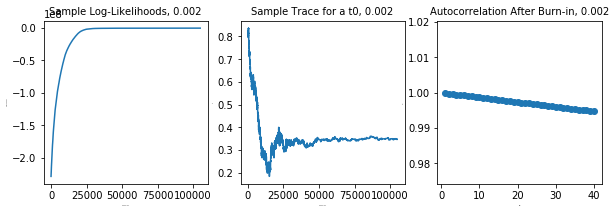

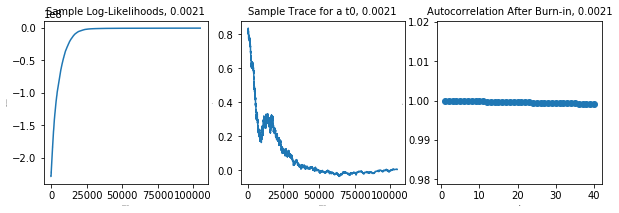

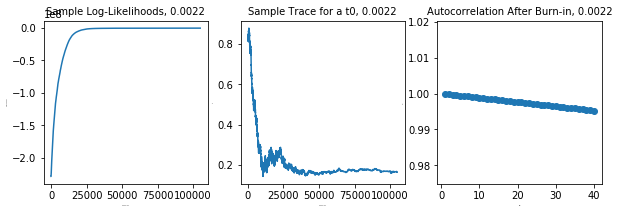

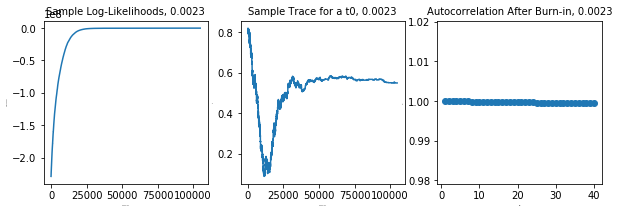

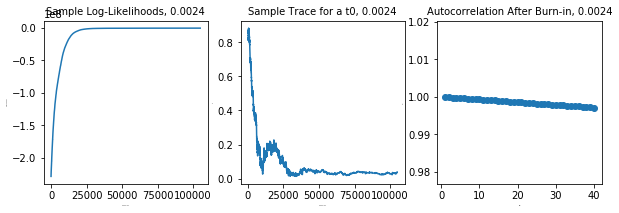

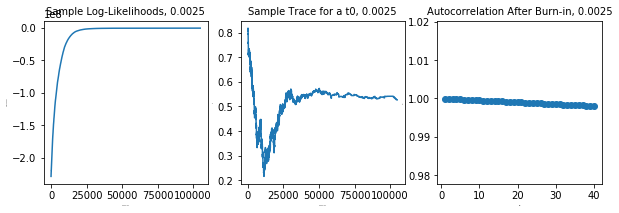

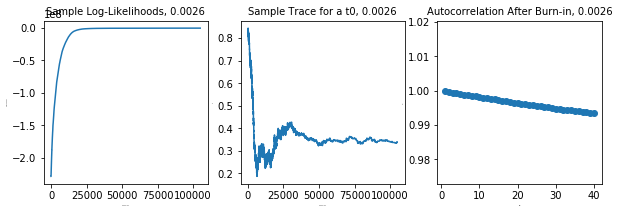

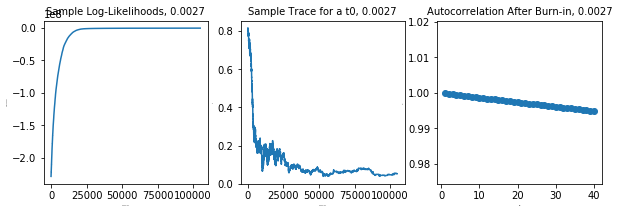

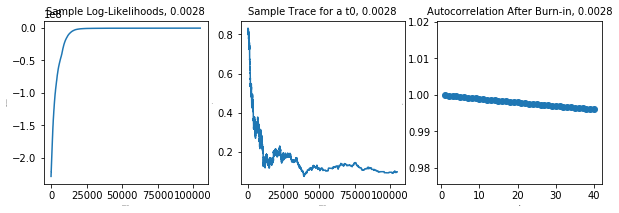

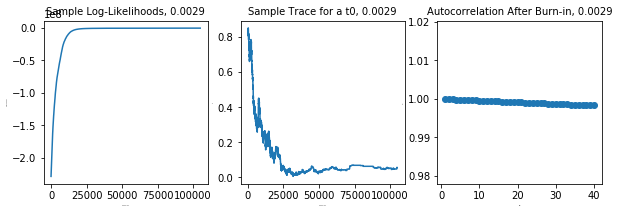

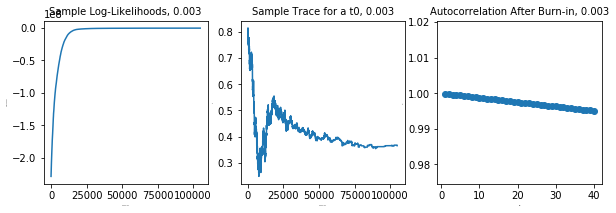

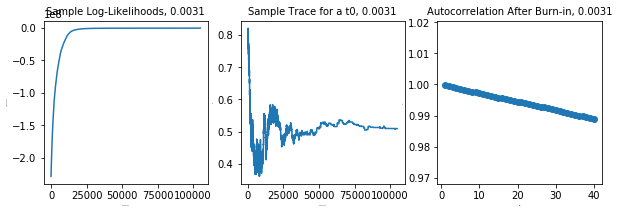

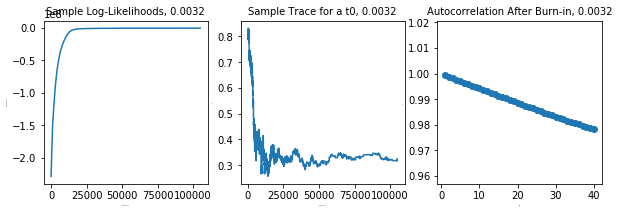

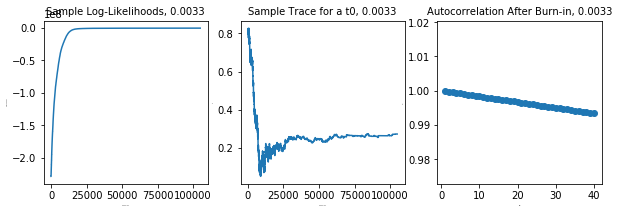

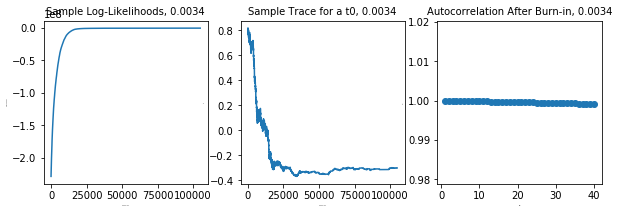

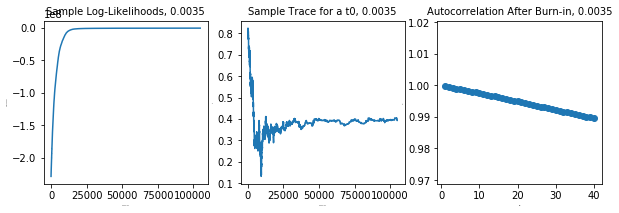

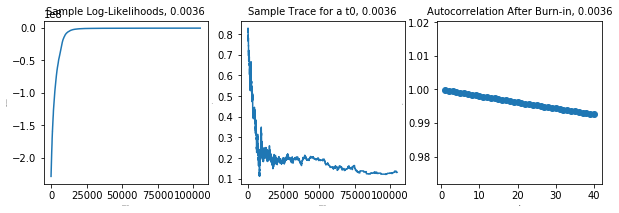

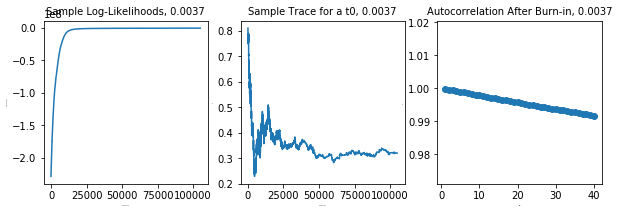

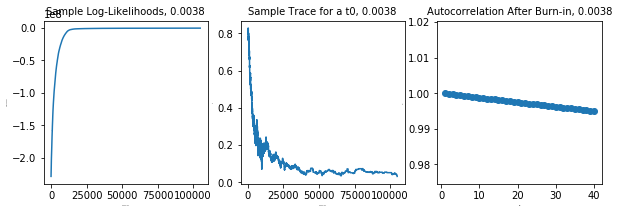

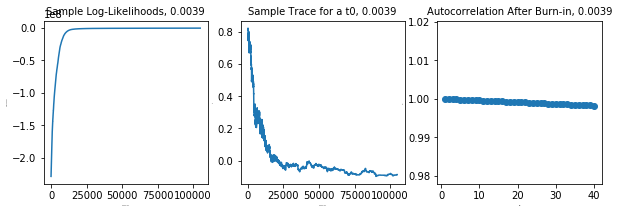

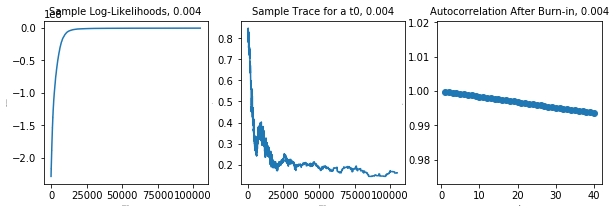

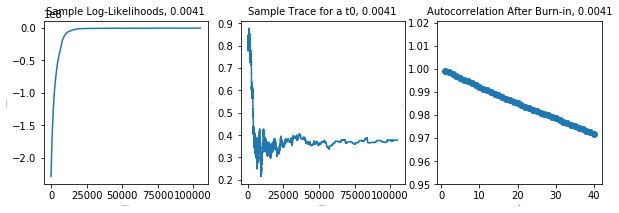

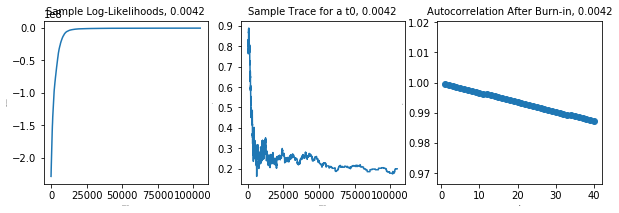

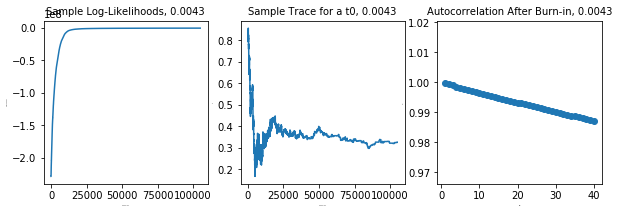

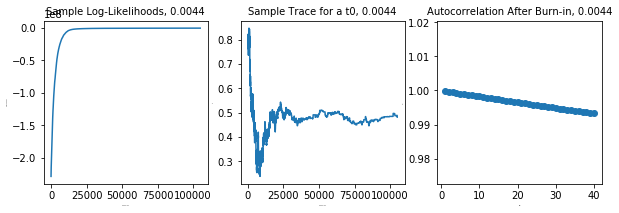

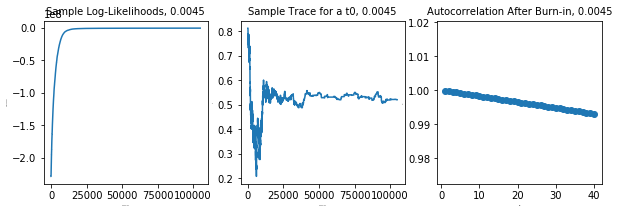

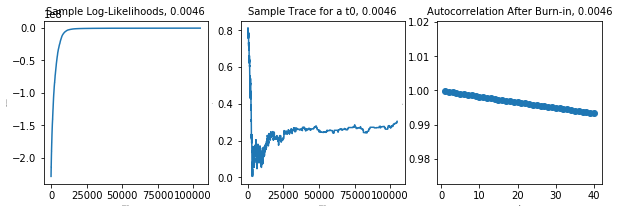

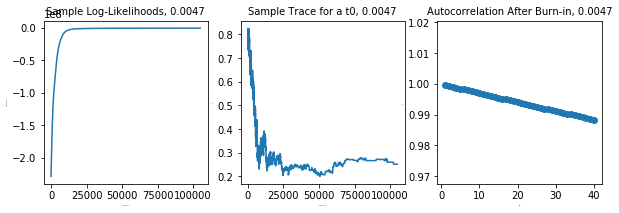

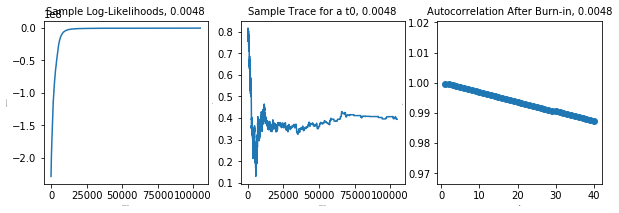

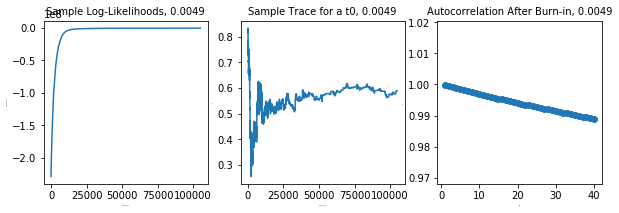

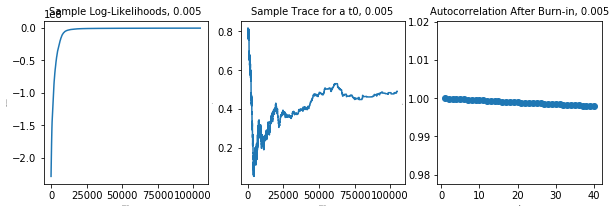

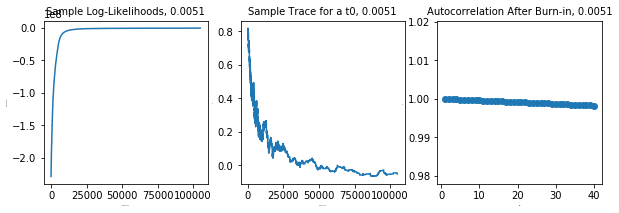

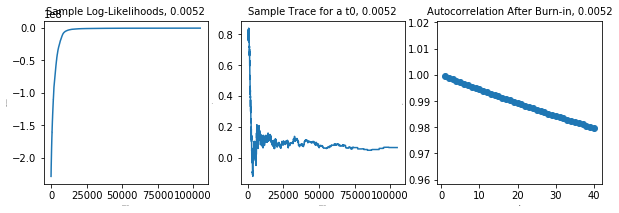

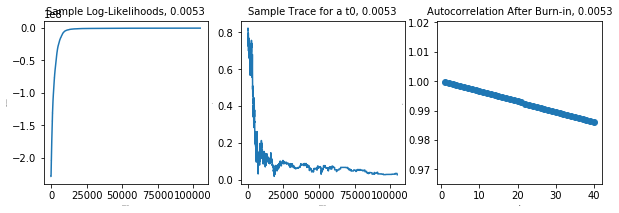

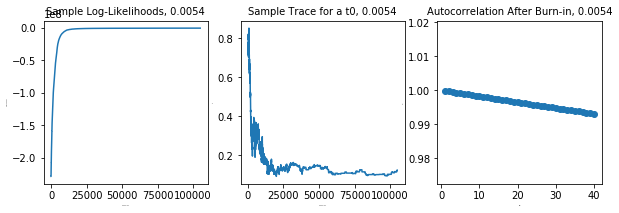

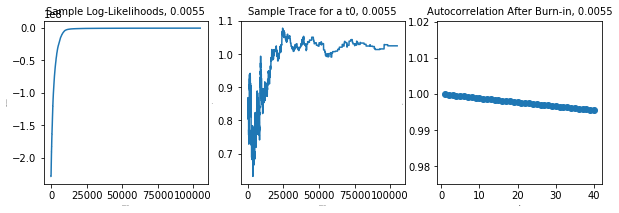

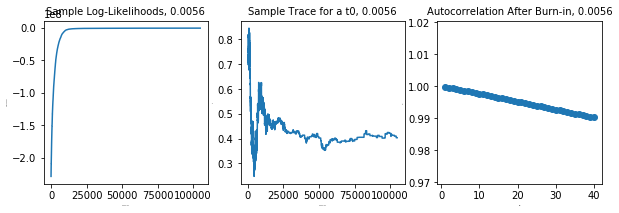

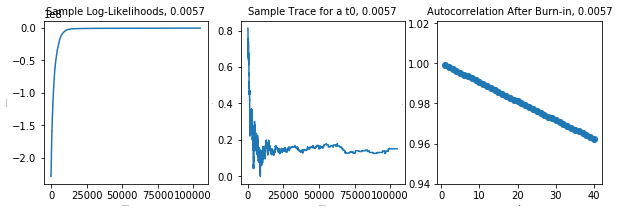

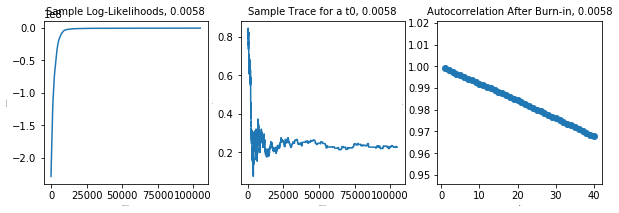

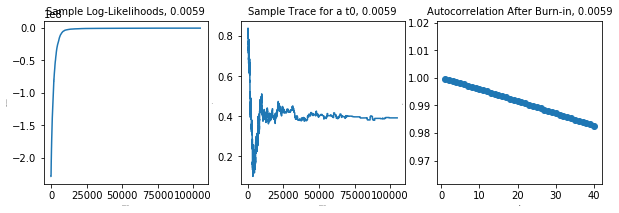

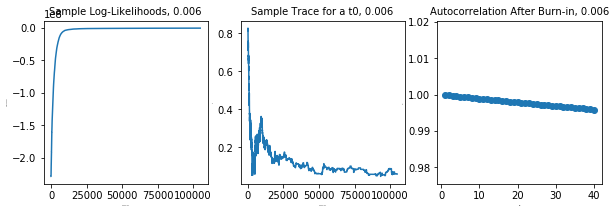

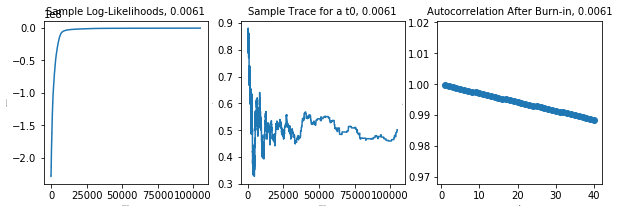

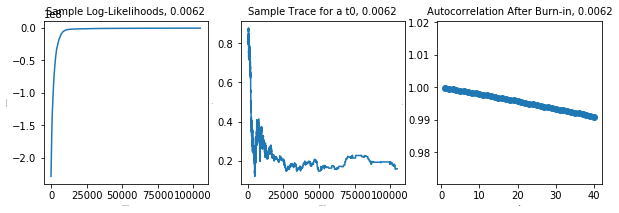

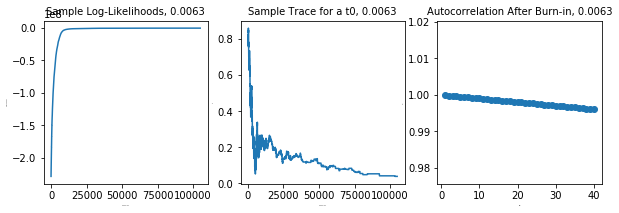

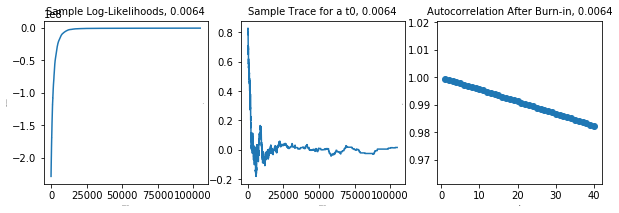

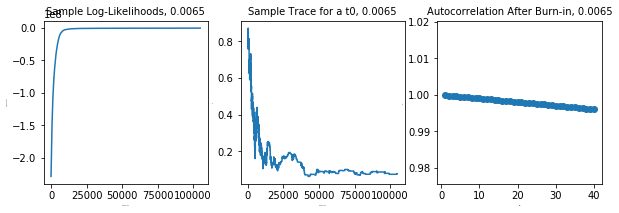

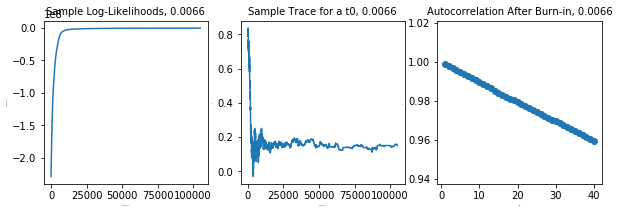

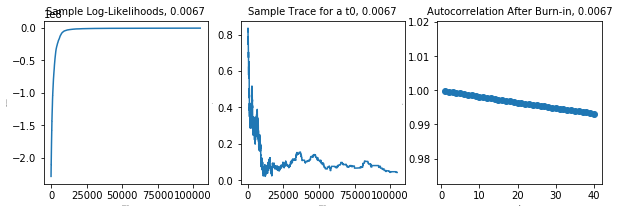

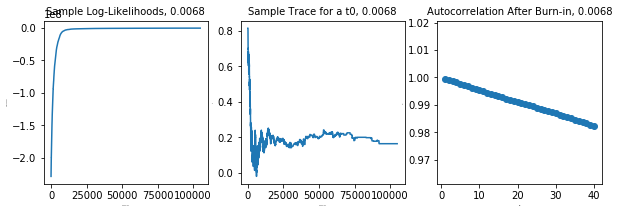

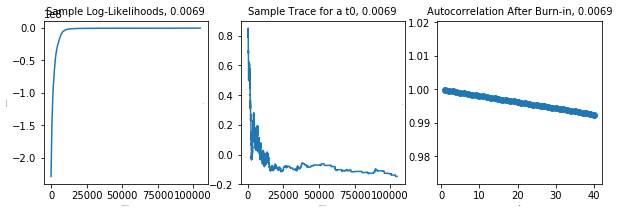

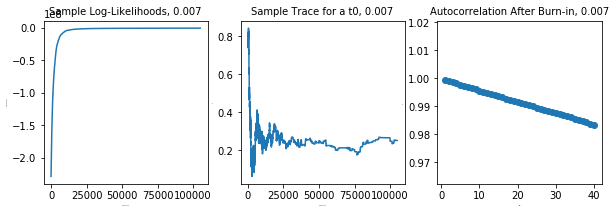

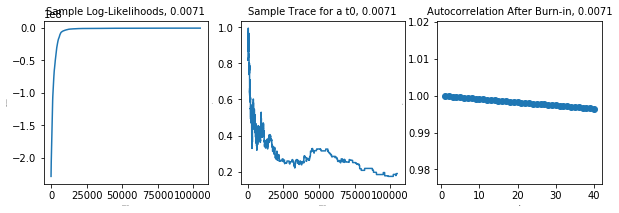

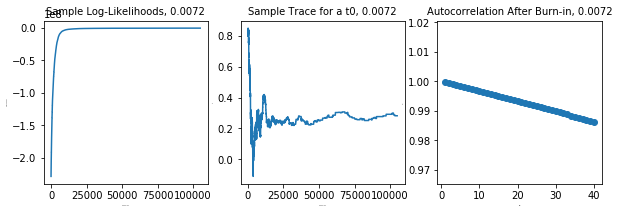

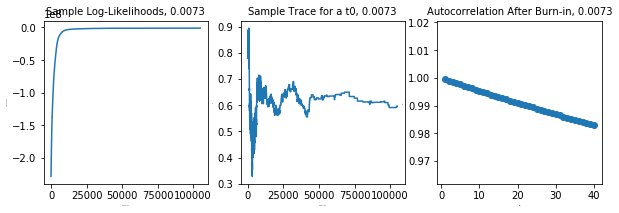

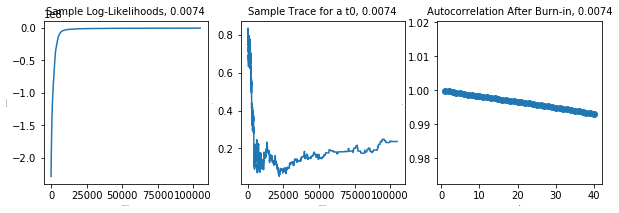

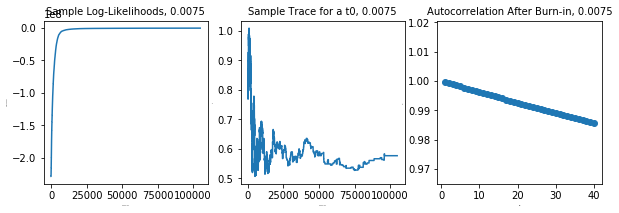

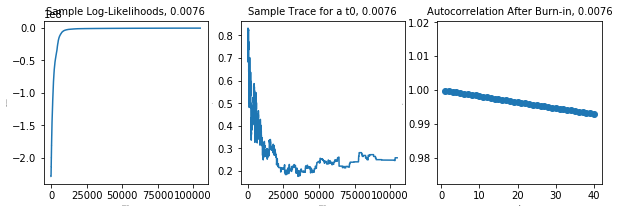

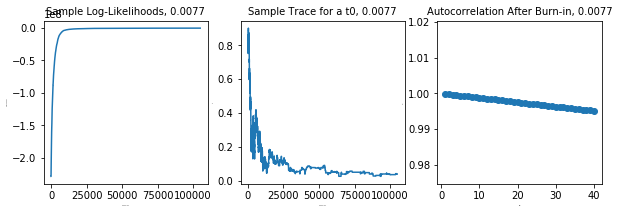

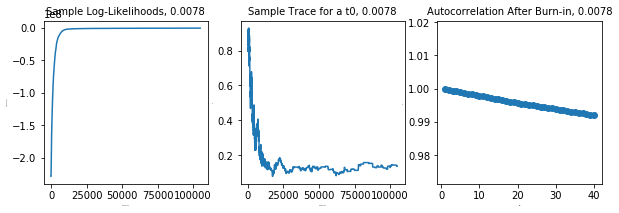

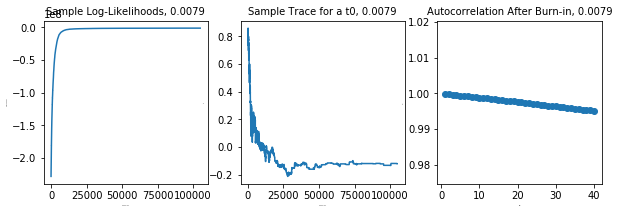

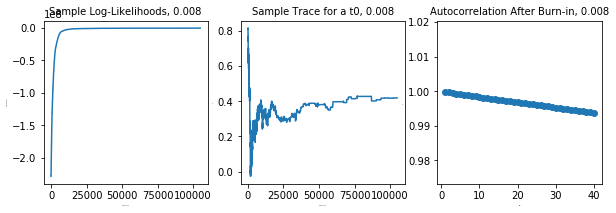

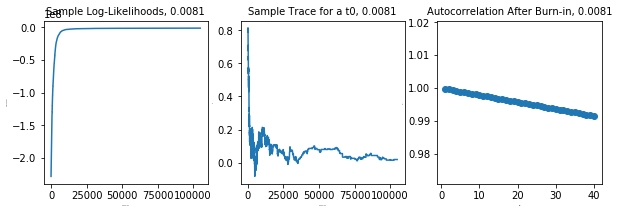

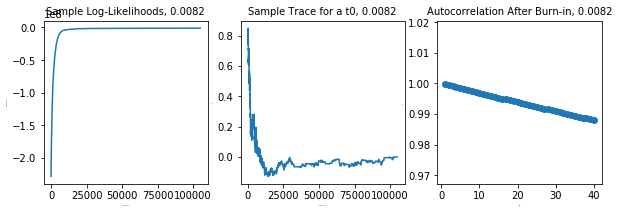

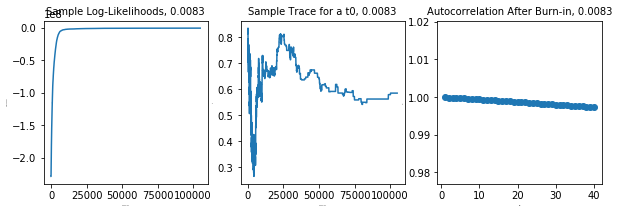

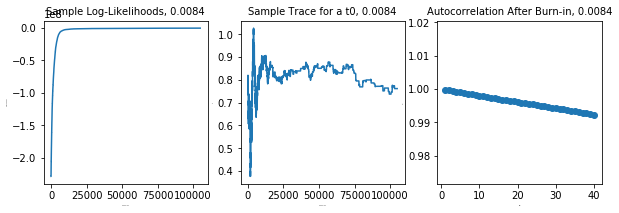

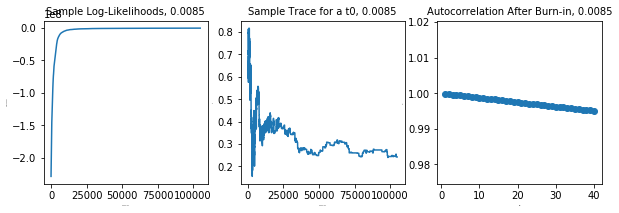

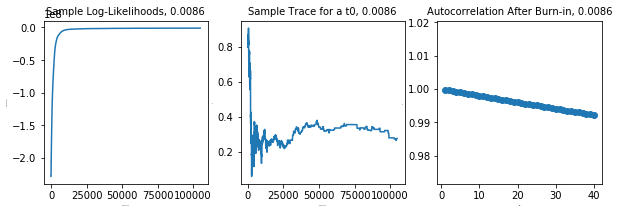

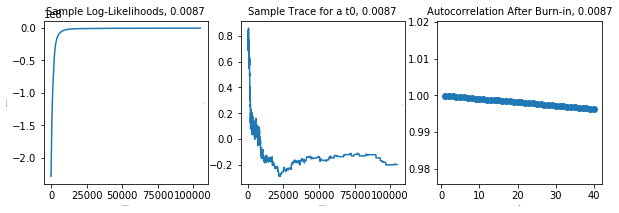

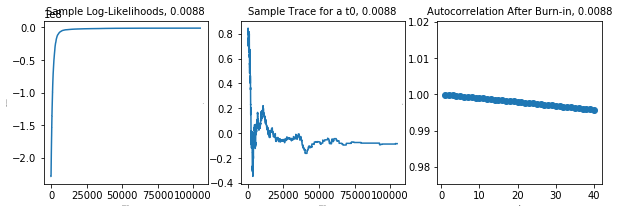

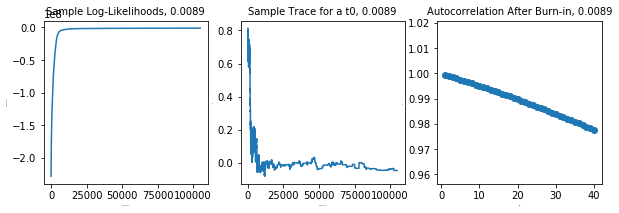

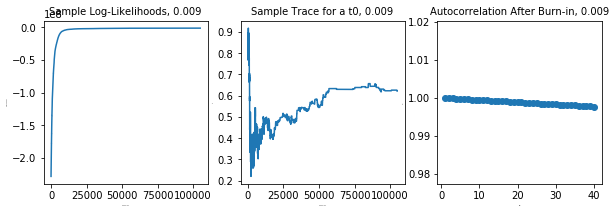

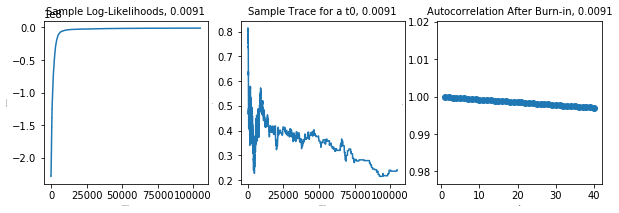

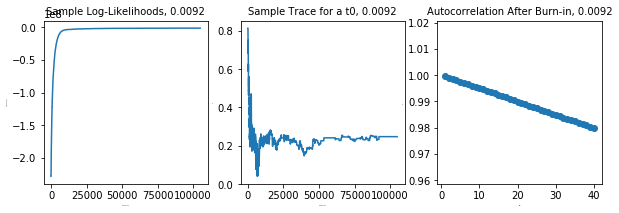

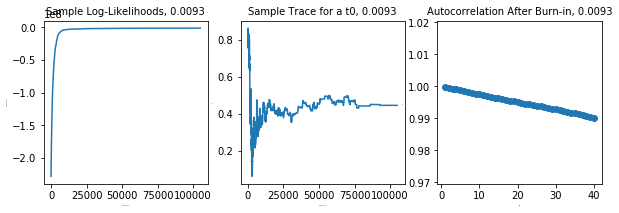

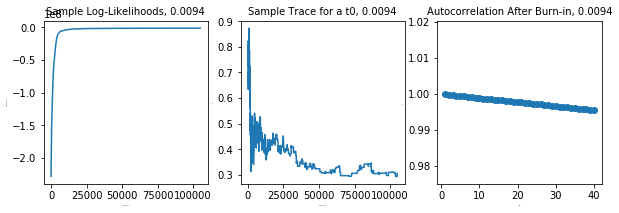

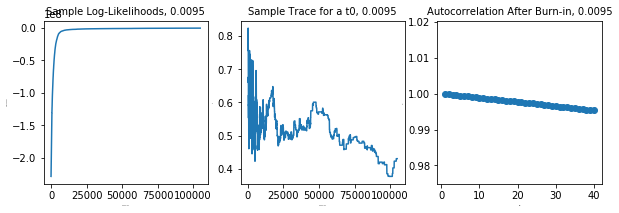

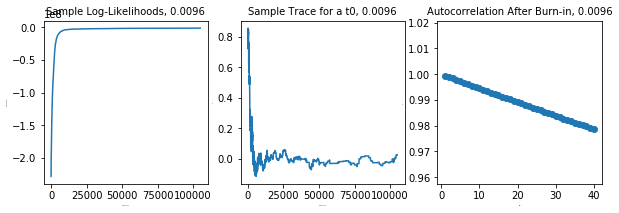

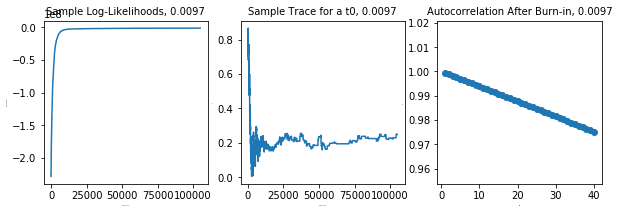

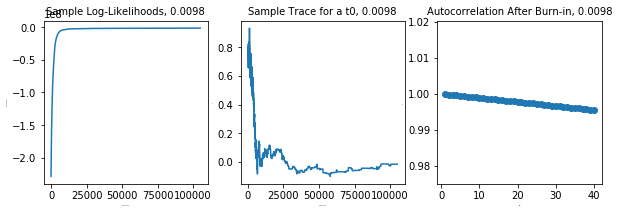

In [ ]:
rcParams['figure.figsize'] = (10,3)
for stepsize in np.arange(.0001,.01,.0001):
    model = LL_LVM(G,epsilon,alpha,V,C_init,t_init,x,stepsize)
    for i in range(100000):
        model.MH_step(burn_in=True)
    for i in range(5000):
        model.MH_step(burn_in=False)
    plt.subplot(1, 3, 1)
    plt.plot(model.likelihoods)
    plt.title("Sample Log-Likelihoods, "+str(stepsize), fontsize=10)
    plt.ylabel("Log Likelihood", fontsize=1)
    plt.xlabel("Sample Index", fontsize=1);
    plt.subplot(1, 3, 2)
    plt.title("Sample Trace for a t0, "+str(stepsize), fontsize=10)
    plt.ylabel("t0", fontsize=1)
    plt.xlabel("Sample Index", fontsize=1);
    plt.plot(model.trace)
    plt.subplot(1, 3, 3)
    plt.title("Autocorrelation After Burn-in, "+str(stepsize), fontsize=10)
    plt.ylabel("ACF", fontsize=1)
    plt.xlabel("Lag", fontsize=1);
    plt.scatter(np.arange(1,41),model.autocorrelation(41))
    plt.show()


In [ ]:
len(np.arange(.0001,.01,.0001))